Our Physical Computing final project depends on a [Pulse Sensor](https://pulsesensor.com/) to detect a user's heartbeat. The people at [World Famous Electronics](https://pulsesensor.com/) created an Arduino library for their customers to use with their sensor. The library adds a lot of value because it provides users with a [well researched algorithm](https://pulsesensor.com/pages/pulse-sensor-amped-arduino-v1dot1) for using the sensor to properly detect a heartbeat. Pulse Sensor users don't have to re-invent the wheel and code their own algorithms. Writing your own algorithm to do this is difficult, and the one provided by the company is better than the one that I came up with for our [midterm](link://slug/heartbeat-detection-study).

Still, the provided algorithm isn't perfect. For some people it seems to miss some heartbeats and add extra heartbeats. A fellow ITP student, Ellen, showed me that it would have odd spikes in the beats-per-minute (BPM) value. It wasn't clear why this was happening. Since I previously had been analyzing the sensor's data in Python, I came up with a plan to figure out why the Arduino code was doing this and to figure out if there was anything I could do about it. After studying the data and making some plots, I was able to make some improvements the algorithm. It still isn't perfect but my changes address many of the weaknesses of the algorithm.

The original Pulse Sensor Arduino code is available [online](https://github.com/WorldFamousElectronics/PulseSensorPlayground) on GitHub. I am sharing this code with my fellow students who are also using the same sensor. After our projects are complete I will submit my modified code to GitHub as a pull request to share with the rest of the community.

<!-- TEASER_END -->

In [1]:
import imp

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt

%matplotlib inline

import pulse_detectors

In [2]:
def read_data(name, date):
    data = pd.read_pickle('data/pulse_data_{0}_{1}.p'.format(date, name))
    # data was collected every 2 ms but I forgot to change the index to time
    # instead of sample index before pickling.
    data.index *= 2
    
    return data

I collected 2 minutes of data for a group of people. Data is sampled in 2 ms intervals.

Here's what the data looks like for me:

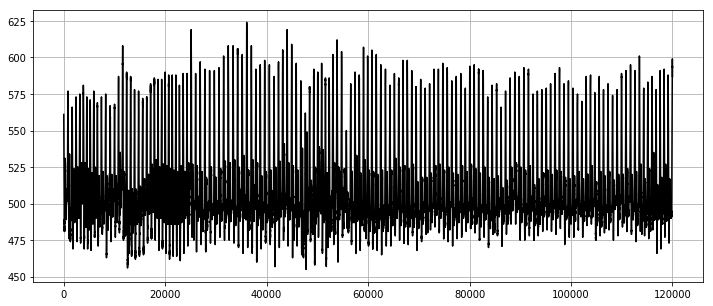

In [3]:
jim_data = read_data('jim', '2017.11.30')

jim_data.plot(figsize=(12, 5), legend=False, color=['k'], grid=True);

If I zoom in I can see a nicely formed pulse:

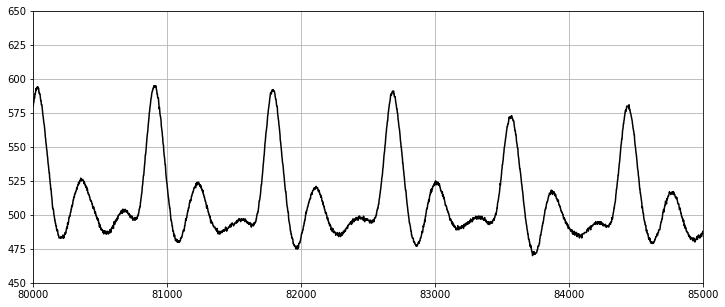

In [4]:
jim_data.plot(figsize=(12, 5), legend=False, color=['k'], grid=True)

plt.xlim([80000, 85000])
plt.ylim([450, 650]);

It should be fairly easy to detect the pulse, right?

Perhaps, but other people have more challenging heart rhythms. Here's the pulse data for Rebecca. Notice the amplitude of her heart rhythm is much smaller than mine. The algorithm still works reaonably well but can get tripped up by some of the noise.

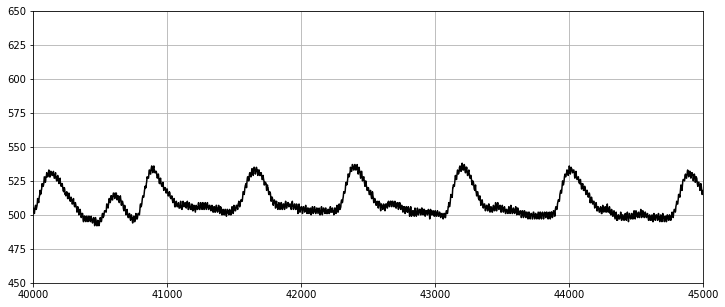

In [5]:
rebecca_data = read_data('rebecca', '2017.11.30')

rebecca_data.plot(figsize=(12, 5), legend=False, color=['k'], grid=True)

plt.xlim([40000, 45000])
plt.ylim([450, 650]);

And Patrick, another ITP student. The amplitude of his heartbeat could vary quite a bit, making it difficult to detect the heartbeats.

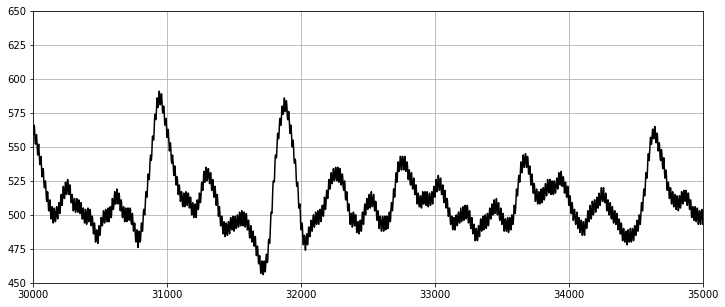

In [6]:
patrick_data = read_data('patrick', '2017.11.30')

patrick_data.plot(figsize=(12, 5), legend=False, color=['k'], grid=True)

plt.xlim([30000, 35000])
plt.ylim([450, 650]);

## Studying the Algorithm

It isn't helpful to look at the above charts and try to imagine how well the algorithm would be able to detect the heartbeats. It is much better to somehow run the algorithm on the data and plot where the detected heartbeats are. This can easily be done in Python and Pandas using the `apply` method.

The Dataframe's `apply` method is a useful tool for running a function on each individual datapoint. But that isn't quite what we need or want here, as the algorithm we wish to simulate depends on more than each datapoint in isolation; it depends on everything that happened before it. It needs to maintain state.

To code this I can create a class that can maintain state, and I can make it callable, allowing me to pass an instance of the class to the `apply` method. It will treat the object as if it were a function.

A high level skeleton of the code:

```python
class PulseSensor:

    def __init__(self):
        # initialization and setup code
        # create state variables

    def __call__(self, x):
        # implementation of the pulse detection algorithm
        # the latest observation is `x`
        # use this to update the state variables and flag beat/not beat

op = PulseSensor()

data['pulse'] = data['reading'].apply(op)
```

With a little bit of effort I can convert the Arduino code to Python and return the algorithm's internal variables, including the boolean `Pulse` variable, used to indicate if a heartbeat is detected at any particular moment. With some more effort, I can also return the other internal variables like the `threshold` used to detect a pulse. I can plot these to diagnose what's going on with the algorithm.

For example:

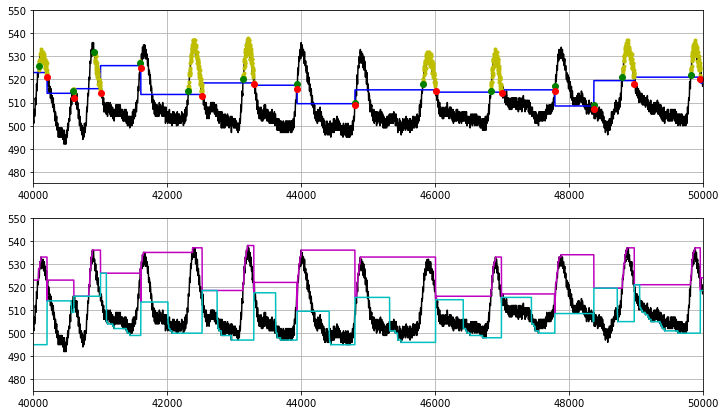

In [7]:
rebecca_data2 = rebecca_data.copy()

op1 = pulse_detectors.PulseSensor()

rebecca_data2['thresh'], rebecca_data2['P'], rebecca_data2['T'], rebecca_data2['beginBeat'], rebecca_data2['endBeat'], rebecca_data2['pulse'], rebecca_data2['bpm'] = zip(*rebecca_data2['reading'].apply(op1))
rebecca_data2['heartbeat'] = rebecca_data2['reading'].where(rebecca_data2['pulse'])

plt.figure(figsize=(12, 7))

ax1 = plt.subplot(211)
plt.plot(rebecca_data2.index, rebecca_data2['reading'], 'k',
         rebecca_data2.index, rebecca_data2['thresh'], 'b',
         rebecca_data2.index, rebecca_data2['heartbeat'], 'y.',
         rebecca_data2.index, rebecca_data2['beginBeat'], 'go',
         rebecca_data2.index, rebecca_data2['endBeat'], 'ro')
plt.grid(True)
plt.ylim([475, 550])

plt.subplot(212, sharex=ax1)
plt.plot(rebecca_data2.index, rebecca_data2['reading'], 'k',
         rebecca_data2.index, rebecca_data2['P'], 'm',
         rebecca_data2.index, rebecca_data2['T'], 'c')
plt.grid(True)
plt.xlim([40000, 50000])
plt.ylim([475, 550]);

This is actual data from Rebecca analyzed using the Python version of the Arduino code provided by World Famous Electronics. In the upper chart, the yellow dots indicate that the `Pulse` variable is `True`, meaning that that portion of the data is flagged as a pulse. The green and red dots indicate the start or end of the identified heartbeat. The blue line is the `threshold` value. This is the dynamically updated value used to detect when the sensor reading is near a peak.

The bottom chart shows the peaks and troughs used to calculate each new threshold.

The way the [algorithm](https://github.com/WorldFamousElectronics/PulseSensorPlayground/blob/master/src/utility/PulseSensor.cpp) currently works is by setting the threshold at the midpoint between the peak and trough of the previous beat. When the sensor reading exceeds this value, it flags the beginning of a heartbeat. After exceeding this value the algorithm waits for the sensor reading to drop below the threshold. When this happens it ends the beat and recalculates the threshold used to detect the next beat.

There's also some additional logic to make sure that the time between the start of beats is at least 60% of the inter-beat interval of the previous two beats. This is to reduce the impact of dichrotic noise and falsely flagged beats. This, along with some other code, makes sure that two beats do not occur too close to one other.

The logic is sound but sometimes it gets tripped up by noise. We can see this clearly in Rebecca's data. Some of the heartbeats end too quickly. Why does this happen? We can see if we zoom in on the data:

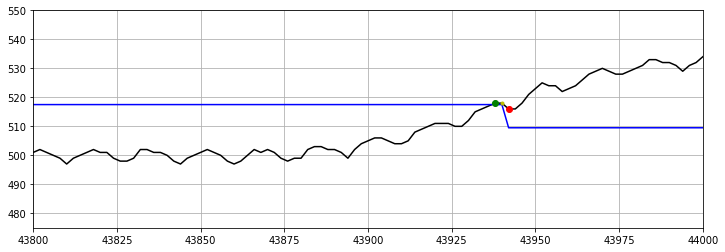

In [8]:
plt.figure(figsize=(12, 4))

plt.plot(rebecca_data2.index, rebecca_data2['reading'], 'k',
         rebecca_data2.index, rebecca_data2['thresh'], 'b',
         rebecca_data2.index, rebecca_data2['heartbeat'], 'y.',
         rebecca_data2.index, rebecca_data2['beginBeat'], 'go',
         rebecca_data2.index, rebecca_data2['endBeat'], 'ro')
plt.grid(True)
plt.xlim([43800, 44000])
plt.ylim([475, 550]);

It detects the start of the heartbeat at the proper time but because of noise the signal drops below the threshold 4 ms later. This ends the heartbeat prematurely.

This wouldn't be a big deal but you'll notice that it sets the threshold at a poor location that is too low compared to the thresholds used in previous beats. It isn't a big deal if we only want to flag the start of heartbeats, but it becomes a problem if the low threshold trips up the algorithm for the next beat. You can see that happen a little bit later in Rebecca's data:

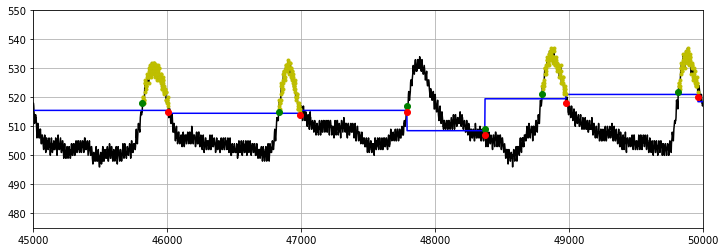

In [9]:
plt.figure(figsize=(12, 4))

plt.plot(rebecca_data2.index, rebecca_data2['reading'], 'k',
         rebecca_data2.index, rebecca_data2['thresh'], 'b',
         rebecca_data2.index, rebecca_data2['heartbeat'], 'y.',
         rebecca_data2.index, rebecca_data2['beginBeat'], 'go',
         rebecca_data2.index, rebecca_data2['endBeat'], 'ro')
plt.grid(True)
plt.xlim([45000, 50000])
plt.ylim([475, 550]);

There's an extra beat! This is the problem that Ellen told me about.

This happened a lot in Patrick's data:

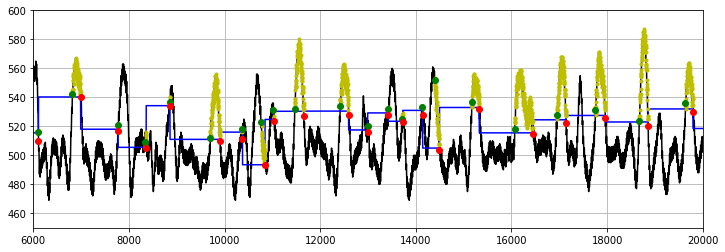

In [10]:
patrick_data2 = patrick_data.copy()

op1 = pulse_detectors.PulseSensor()

patrick_data2['thresh'], patrick_data2['P'], patrick_data2['T'], patrick_data2['beginBeat'], patrick_data2['endBeat'], patrick_data2['pulse'], patrick_data2['bpm'] = zip(*patrick_data2['reading'].apply(op1))
patrick_data2['heartbeat'] = patrick_data2['reading'].where(patrick_data2['pulse'])


plt.figure(figsize=(12, 4))

plt.plot(patrick_data2.index, patrick_data2['reading'], 'k',
         patrick_data2.index, patrick_data2['thresh'], 'b',
         patrick_data2.index, patrick_data2['heartbeat'], 'y.',
         patrick_data2.index, patrick_data2['beginBeat'], 'go',
         patrick_data2.index, patrick_data2['endBeat'], 'ro')
plt.grid(True)
plt.xlim([6000, 20000])
plt.ylim([450, 600]);

I see this same problem in a lot of the collected data.

The main problem here is that the algorithm selects its heartbeat detection parameters completely with the previous beat and not anything that happened before it. One mistake can have a chain reaction that will trip up the algorithm for future beats.

This issue can also cause missed beats. In Asha's data, one unexpectedly large beat caused the threshold to be set too high, resulting in several skipped beats.

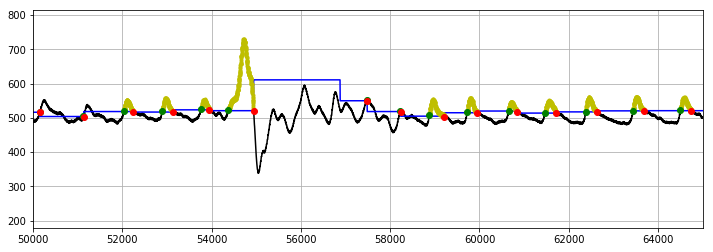

In [11]:
asha_data = read_data('asha', '2017.11.30')

asha_data2 = asha_data.copy()

op1 = pulse_detectors.PulseSensor()

asha_data2['thresh'], asha_data2['P'], asha_data2['T'], asha_data2['beginBeat'], asha_data2['endBeat'], asha_data2['pulse'], asha_data2['bpm'] = zip(*asha_data2['reading'].apply(op1))
asha_data2['heartbeat'] = asha_data2['reading'].where(asha_data2['pulse'])


plt.figure(figsize=(12, 4))

plt.plot(asha_data2.index, asha_data2['reading'], 'k',
         asha_data2.index, asha_data2['thresh'], 'b',
         asha_data2.index, asha_data2['heartbeat'], 'y.',
         asha_data2.index, asha_data2['beginBeat'], 'go',
         asha_data2.index, asha_data2['endBeat'], 'ro')
plt.grid(True)
plt.xlim([50000, 65000]);

## Algorithm Improvements

I can make some small changes to the algorithm to address these problems.

First I modified the algorithm's threshold to be the 10-beat exponential moving average of thresholds. This makes it slower to increase or decrease the threshold but also makes it more resistant to noise. There will be less skipped or missed beats, and if a skipped or double beat does happen, it will help avoid a chain reaction.

I also changed the algorithm so the threshold uses a point higher than the midpoint between the peak and the trough. This seems to offer better protection against noise.

Next I added a check to make sure that a beat will not end right after it starts. The minimum duration of a beat is 100 ms, protecting it from the problem we saw above when noise caused the signal to drop below the threshold. This is an addition to original algorithm's requirement that a new beat must start at least 250 ms after the start of the previous beat's start time.

Finally, I applied a 10 beat exponential moving average to the inter-beat-interval used in the algorithm. This makes it less vulnerable to skipped beats. This smoothed IBI value is used to calculate the pulse rate, or BPM. This address's Ellen's previously reported problem of seeing large and unexplained spikes in the pulse rate.

## New Algorithm

How well does the new algorithm work? Let's plot the results.

Here's Rebecca's data, which previously had double beats.

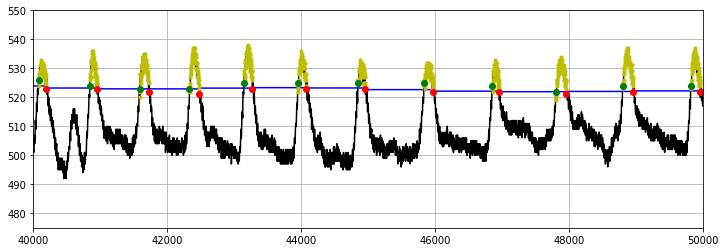

In [12]:
rebecca_data2 = rebecca_data.copy()

op2 = pulse_detectors.PulseSensor2()

rebecca_data2['thresh'], rebecca_data2['P'], rebecca_data2['T'], rebecca_data2['beginBeat'], rebecca_data2['endBeat'], rebecca_data2['pulse'], rebecca_data2['bpm'] = zip(*rebecca_data2['reading'].apply(op2))
rebecca_data2['heartbeat'] = rebecca_data2['reading'].where(rebecca_data2['pulse'])

plt.figure(figsize=(12, 4))

plt.plot(rebecca_data2.index, rebecca_data2['reading'], 'k',
         rebecca_data2.index, rebecca_data2['thresh'], 'b',
         rebecca_data2.index, rebecca_data2['heartbeat'], 'y.',
         rebecca_data2.index, rebecca_data2['beginBeat'], 'go',
         rebecca_data2.index, rebecca_data2['endBeat'], 'ro')
plt.grid(True)
plt.xlim([40000, 50000])
plt.ylim([475, 550]);

Patrick's data still has two extra beats but they don't cause the same chain reaction that causes more extra beats.

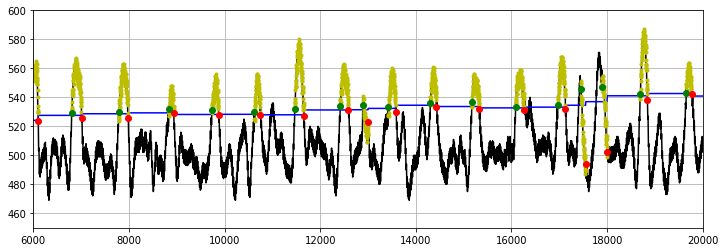

In [13]:
patrick_data2 = patrick_data.copy()

op2 = pulse_detectors.PulseSensor2()

patrick_data2['thresh'], patrick_data2['P'], patrick_data2['T'], patrick_data2['beginBeat'], patrick_data2['endBeat'], patrick_data2['pulse'], patrick_data2['bpm'] = zip(*patrick_data2['reading'].apply(op2))
patrick_data2['heartbeat'] = patrick_data2['reading'].where(patrick_data2['pulse'])


plt.figure(figsize=(12, 4))

plt.plot(patrick_data2.index, patrick_data2['reading'], 'k',
         patrick_data2.index, patrick_data2['thresh'], 'b',
         patrick_data2.index, patrick_data2['heartbeat'], 'y.',
         patrick_data2.index, patrick_data2['beginBeat'], 'go',
         patrick_data2.index, patrick_data2['endBeat'], 'ro')
plt.grid(True)
plt.xlim([6000, 20000])
plt.ylim([450, 600]);

Asha's data still has two missed beats but the are not simultaneous.

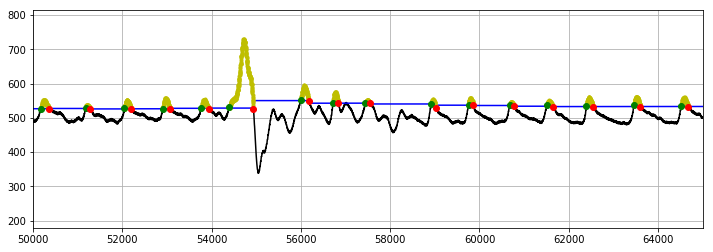

In [14]:
asha_data2 = asha_data.copy()

op2 = pulse_detectors.PulseSensor2()

asha_data2['thresh'], asha_data2['P'], asha_data2['T'], asha_data2['beginBeat'], asha_data2['endBeat'], asha_data2['pulse'], asha_data2['bpm'] = zip(*asha_data2['reading'].apply(op2))
asha_data2['heartbeat'] = asha_data2['reading'].where(asha_data2['pulse'])


plt.figure(figsize=(12, 4))

plt.plot(asha_data2.index, asha_data2['reading'], 'k',
         asha_data2.index, asha_data2['thresh'], 'b',
         asha_data2.index, asha_data2['heartbeat'], 'y.',
         asha_data2.index, asha_data2['beginBeat'], 'go',
         asha_data2.index, asha_data2['endBeat'], 'ro')
plt.grid(True)
plt.xlim([50000, 65000]);

As we can see the modified algorithm still isn't perfect but it is more robust to data problems that invariably will happen with this pulse sensor.

Our project now uses the updated algorithm and we are pleased with the results. We are now able to detect the Pulse of hard-to-measure students like Roland. Roland has a weak pulse and it is hard to detect the beats of his heart.

I have shared this code with the other ITP students that are using the same pulse sensor. I am happy to contribute to their projects. Their testing will contribute to our testing just as our testing contributes to theirs. We are sharing our test results and communicating best practices about using this sensor. We are also discussing people we have identified as having hard to detect pulses and targeting them for additional testing.

The general approach above for algorithm development is sound and effient. It would be crazy for us to tweak the parameters of the Arduino code directly and repeatedly retest on a group of people in an attempt to make something that works for everyone. Extracting the data and evaluating algorithm performance in Python is better use of everyone's time.

One improvement I could do if I had more time is to try to quantify the accuracy of each algorithm so I can make more specific statements about the value of each. Right now my evaluations are more anecdotal which is a poor practice. To be more rigorous I should manually classify my data and then compare my classifications with the classifications derived by the algorithm. That level of rigor is not needed right now and is out of scope for this class.